### SSD (1) SSD의 특징

#### SSD : Single Shot MultiBox Detector

YOLO가 1 stage로 object detection을 할 수 있다는 증명을 한 뒤, 1 stage detector는 수많은 발전을 이루었다. SSD는 YOLO v1에서 grid를 사용해서 생기는 단점을 해결할 수 있는 아래와 같은 몇가지 테크닉을 제안했다.

1. Pre-defined Anchor Box

2. Image Pyramid

이제부터 SSD에 대한 자세한 내용을 논문 SSD: Single Shot MultiBox Detector을 참고로 하여 설명해 보겠다.

https://arxiv.org/pdf/1512.02325.pdf

#### SSD의 Workflow

YOLO v1의 두번째 단점은 box 정보 (x,y,w,h)를 예측하기 위한 seed 정보가 없기 때문에 넓은 bbox 분포를 모두 학습할 수 없었다는 점이다. 이로 인한 성능 손실이 존재할 수 있었다. 따라서 Faster R-CNN 등에서 사용하는 anchor를 적용할 필요가 있었다.

만약 개가 등장하는 bounding box가 존재한다면, 그 bounding box만의 x,y,w,h 특성이 존재하기 때문에 pre-defined된 box의 x,y,w,h를 refinement하는 layer를 추가하는 것이 이득이었다. 이 anchor box를 SSD에서는 Default box라고 부른다.

#### Image Pyramid

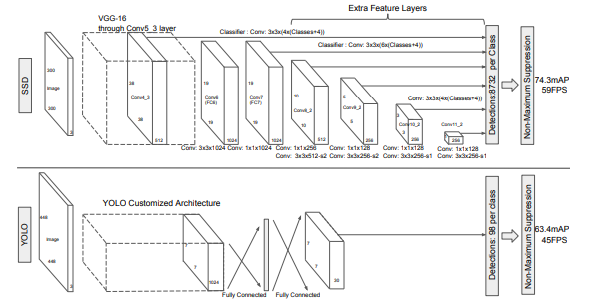

Image Pyramid는 ImageNet으로 사적학습된 VGG16을 사용한다. VGG에서 pooling layer를 거친 block은 하나의 image feature로 사용 가능하다.

YOLO에서 7 x 7 크기의 feature map 하나만을 사용했다면, SSD는 38 x 38, 19 x 19, 10 x 10, 5 x 5, 3 x 3, 1 x 1인 다양한 크기의 featur map을 사용하였다. 각 feature map은 YOLO 관점에서 보면 원본 이미지에서 grid 크기를 다르게 하는 효과가 있었다. 따라서 5 x 5 크기의 feature map에서 grid가 너무 커서 작은 물체를 못찾는 문제를 38 x 38 크기의 feature map에서 찾을 수 있는 단서를 마련했다.

즉 SSD는 서로 다른 크기의 feature map에서 object detection을 해서 작은 물체는 큰 feature map에서, 큰 물체는 작은 feature map에서 찾을 수 있게 한 것이다. 각 단계에서 추출된 feature map은 detector와 classifier를 통과해 object detection을 한다.

각 feature map에는 bounding box와 클래스 정보가 담겨 있는데, 이 feature map들을 2번 convolution한다. 위의 그림에서 보면 Classifier: Conv: ...라고 쓰여있는 부분에서 1번 더 convolution을 하게 된다. 3 x 3 x (default box의 수 x (class의 수 + 4)의 가중치로 convolution을 하여 n x n x (default box의 수 x (class의 수+4))의 feature map을 얻게 된다. 여기서 class는 PASCAL VOC의 클래스 20개와 배경 클래스를 합해 21이고, + 4는 bounding box의 위치 정보 x, y, w, h의 개수를 의미한다.



아래의 그림은 위의 그림에서 생략되었던 detector와 classifier를 포함한 아키텍처를 보여준다. 각각의 feature map에서 뽑아낸 6개의 classifier의 예측을 NMS를 사용해 confidence가 가장 높은 box 하나만 남겨 최종 detection을 한다.

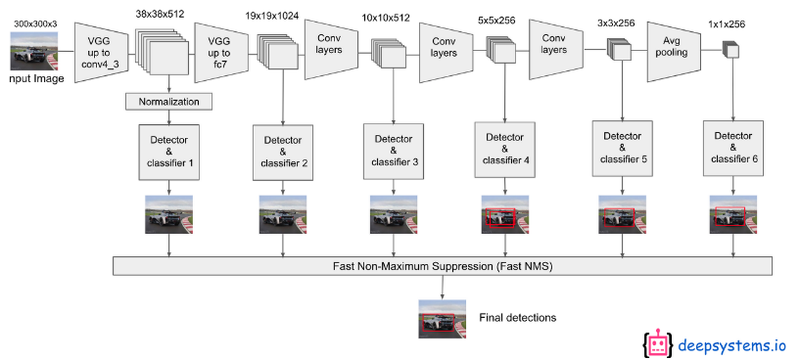

#### SSD의 framework

SSD는 입력 이미지와 각 객체에 대한 ground truth box만을 필요로 한다. convolution을 할 때 비율이 다른 default box를 설정하는데, 아래의 그림은 다른 크기의 feature map에서, 각 객체마다 다른 비율의 default box를 4개씩 만들어 놓은 것을 표현한 것이다. 각 default box에서 default box와 대응되는 bounding box regression을 적용하여 box의 (x, y, w, h)를 찾고 confidence, 즉 box 안에 물체가 있는지 없는지를 예측하는 점수를 예측한다.

학습할 때 이 default box와 ground truth box를 비교해 ground truth box와 비슷한 default box를 선택하여 positive, 나머지는 negative로 설정한다. 고양이는 개보다 작기 때문에 8 x 8 feature map에서는 고양이를 잡아내고, 4 x 4 feature map에서는 개를 잡아낸 것을 볼 수 있다.

이렇게 각 레이어에서 피쳐 맵들을 가져와 Object Detection을 수행한 결과들을 모두 합하여 localization loss와 confidence loss를 구한 다음, 전체 네트워크를 학습시키는 방식으로 1 Step end-to-end Object Detection 모델을 구성하였다.

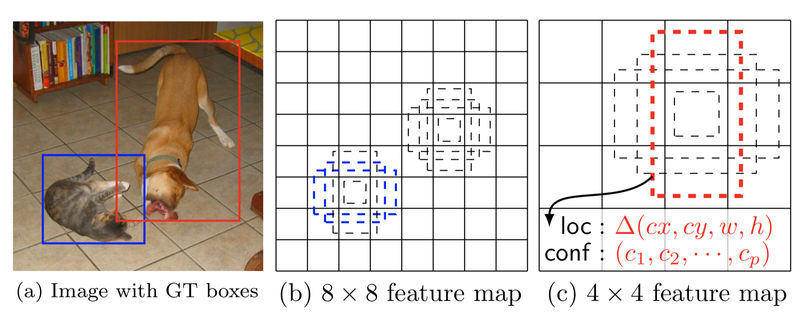

#### Default box를 위한 scale

다양한 크기의 Default box 생성을 위해 SSD는 아래와 같은 식을 사용한다.

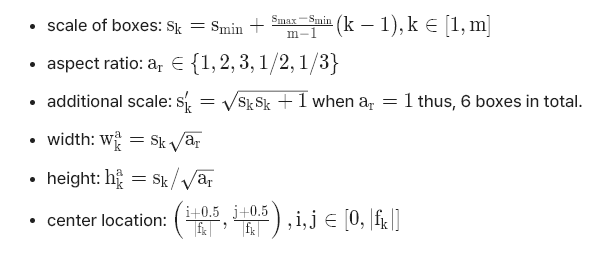

feature map의 개수를 m, S_{min}S 
min
​
 을 0.2, S_{max}S 
max
​
 를 0.9라고 하고, 위의 식에 넣으면 각 feature map당 서로 다른 6개의 s 값(scale 값) [0.2, 0.34, 0.48, 0.62, 0.76, 0.9]이 나온다. 이 값은 각 feature map에서 default box의 크기가 입력 이미지의 너비와 높이에 비해 얼마나 큰 지를 보여준다.



여기서 aspect ratio를 {1, 2, 3, 1/2, 1/3}로 설정하여 default box의 너비와 높이를 구할 수 있다. 예를 들어 k=3이라면 scale은 0.48이며 aspect ration가 2라면 너비는 0.68, 높이는 0.34이다. 논문에서는 1개의 box를 더 추가해 총 6개의 default box의 너비와 높이 값을 구한다.

입력 이미지에서 default box가 위치할 중심점(center location)의 식에서 fk
​
 는 k번째 feature map의 크기이다. 대략 예측되는 상자가 정사각형이나 가로로 조금 길쭉한 상자, 세로로 조금 길쭉한 상자이기 때문에 2:3으로 임의로 정해도 학습이 잘 되지만, 특이한 경우, 즉 가로 방향으로 걸어가는 지네와 같은 경우에 위의 비율로 정하면 threshold를 0.5로 했을 때 학습이 되지 않는다. 따라서 학습할 이미지에 따라서 aspect ration를 조정해야 한다. 임의로 정하는 것은 비효율적이므로 KNN과 같은 알고리즘을 활용하면 좋은 결과가 나올 것이다.

이렇게 구해준 중심점 좌표들에 원래의 입력 이미지의 크기를 곱해 중심점을 구하고, 각 중심점마다 default box를 그릴 수 있다. 이를 시각화하면 아래와 같다. 

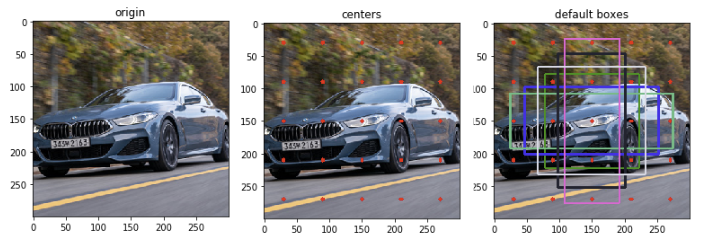

### SSD (2) SSD의 Loss와 성능

#### Matching strategy

학습 전에 ground truth와 defalt box의 jaccard overlap(IoU)이 0.5 이상인 것을 미리 매칭시켜 positive sample로 설정한다. jaccard overlap이 0.5 이상인 default box를 모두 사용하면 학습 문제를 단순화시켜서 더 높은 성능을 가져올 수 있다.

https://en.wikipedia.org/wiki/Jaccard_index

#### SSD Loss function

SSD Loss function의 식은 아래와 같다.

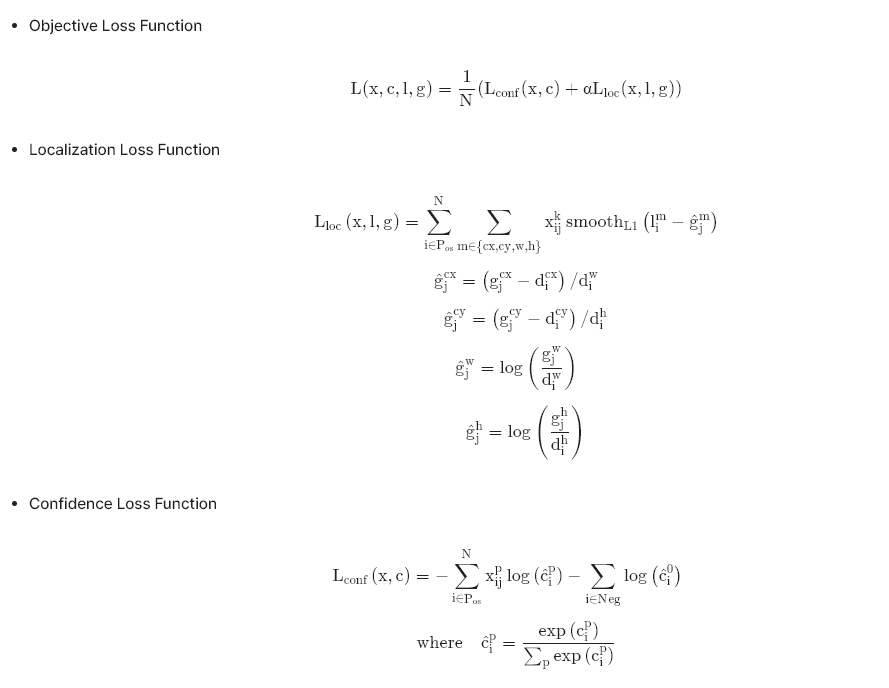

우선 위의 식에서 사용한 용어를 정리하면 아래와 같다.

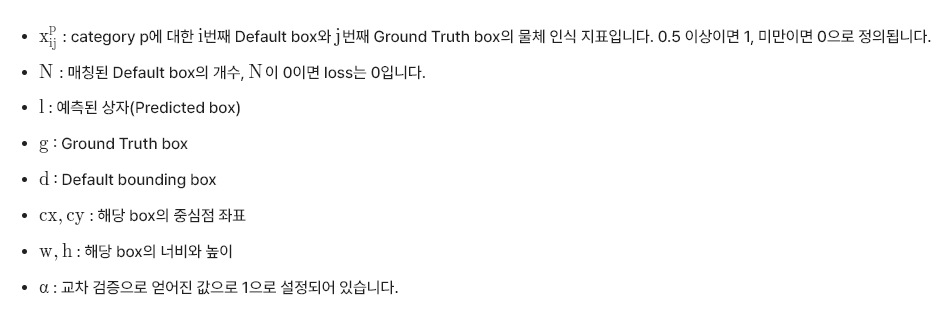

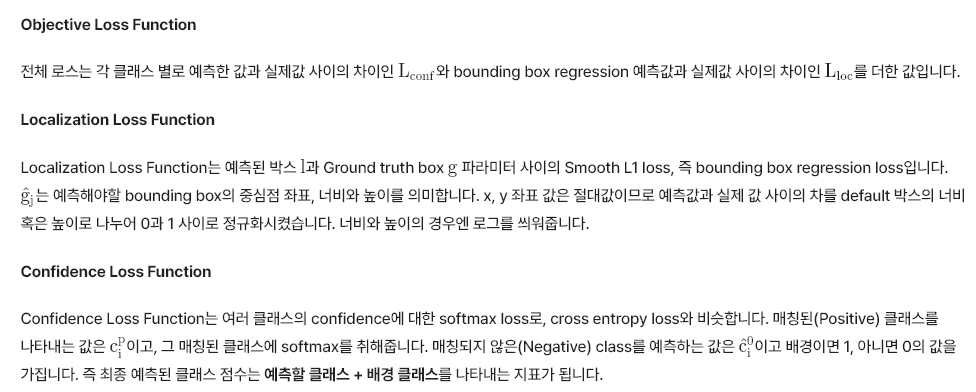

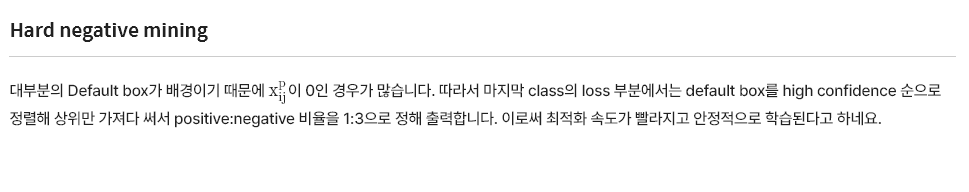

#### SSD 성능

SSD의 성능은 아래와 같이 Faster R-CNN보다는 성능이 조금 낮지만 속도는 빠르고, YOLO보다는 성능이 높고 속도는 느리다. SSD가 속도와 정확성을 동시에 잡자는 목표를 갖고 있었다는 것을 생각해보면, 그 목표를 이룬 것 같죠?

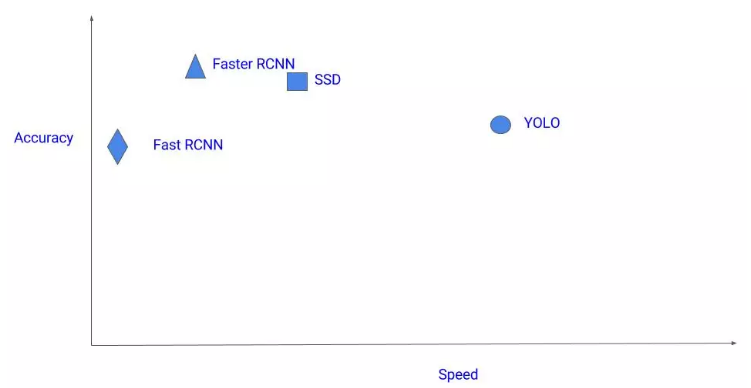

YOLO가 작은 물체를 잘 찾아내지 못했던 것 역시 SSD에서는 어느 정도 해결한 것 같다. 심지어 YOLO v2보다 성능이 더 좋다는 것을 알 수 있다.

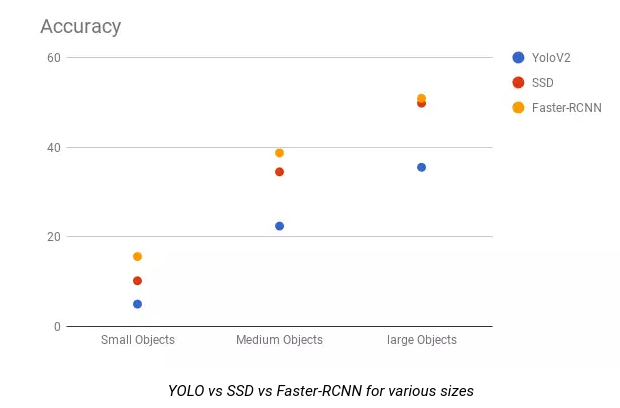

#### FCOS

FCOS:Fully Convolutional One-Stage Object Detectionan는 기존의 anchor box기반에서 벗어나 pixelwise로 예측하는 FCOS를 제안했다. Anchor box를 사용하면서 생기는 부작용(예: 학습 계산량, 하이퍼파라미터에 민감한 성능 등)을 해결하면서도 좋은 성능을 보입니다.

https://blog.naver.com/NBlogTop.naver?blogId=tomatian&Redirect=Dlog&Qs=/jinyuri303/221876480557

### Face Detection을 위한 모델들

지금까지 One-Stage Detection의 가장 대표적인 두가지 모델인 YOLO와 SSD에 대해 살펴보았다. 다음 실습에서는 SSD를 활용한 Face Detection을 실제로 구현해 보는 과정을 통해 더욱 깊이있게 알아보게 될 것이다.

SSD 이후로 특히 Face Detection 모델이 지속적으로 발표되었다. papers with code에서 검색하면 Face Detection에 대한 다양한 모델을 살펴볼 수 있다.

그럼 SOTA Face Detection 모델을 중심으로 간단히 살펴볼까?

#### TinaFace


논문 TinaFace: Strong but Simple Baseline for Face Detection에서는 Face Detection과 Object Detection이 다르지 않다는 점을 지적하면서, Object Detection에서 사용했던 기법을 사용해 단순하지만 좋은 성능을 보이는 모델인 TinaFace를 소개한다. TinaFace는 백본으로 ResNet50을 사용했고 기존에 존재했던 모듈(Feature Pyramid Network, Inception block, FCN 등)을 활용해 만들어졌다. 자세한 내용은 논문을 참고해 보자.

https://arxiv.org/pdf/2011.13183v3.pdf

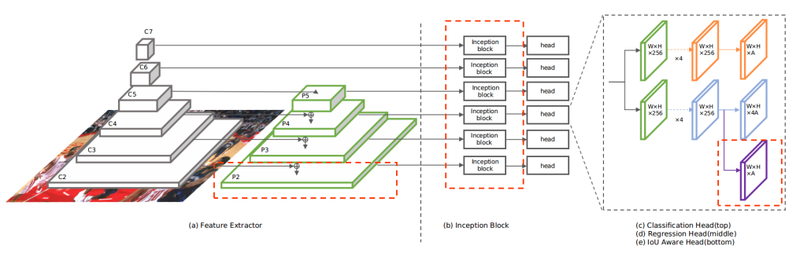

#### RetinaFace

RetinaFace는 1-Stage face detector로서, 다양한 얼굴 크기에 대해 pixel-wise face localization을 수행했다. 이를 위해 기존의 box classification과 regression 브랜치와 함께 extra-supervised and self-supervised multi-task learning을 하였다고 한다. 그 결과는 아래의 그림에 나와 있듯 face score, face box, 5개의 얼굴 랜드마크, 3D face vertices(정점)라고 한다. 자세한 내용은 논문 RetinaFace: Single-stage Dense Face Localisation in the Wild을 참고해 보자.

https://arxiv.org/pdf/1905.00641.pdf

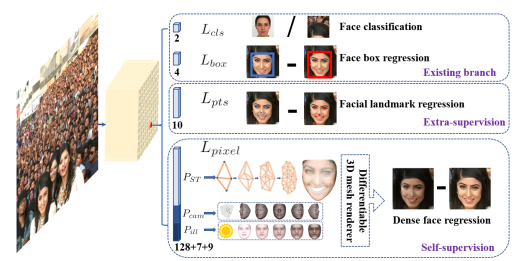

#### DSFD

DSFD는 Feature Enhance Module(FEM), Progressive Anchor Loss(PAL), Improved Anchor Matching (IAM)라는 기법을 사용해 성능을 높인 모델이다, 언급한 세 기법이 two-stream으로 디자인되어 있어서 Dual Shot Face Detector라는 이름이 붙었다고 한다. 자세한 내용은 논문 DSFD: Dual Shot Face Detector을 참고해 보자.

https://arxiv.org/pdf/1810.10220.pdf

#### S3FD



S3FD는 하나의 deep neural network를 사용해 다양한 얼굴 크기에 대해 face detection을 수행하며, 특히 작은 얼굴을 잘 찾는 모델입니다. 다양한 크기의 얼굴을 잘 찾기 위해 layer의 넓은 범위에 anchor를 바둑판 형식으로 배열하였고, anchor 크기도 새롭게 디자인했다고 한다. 그 외에도 작은 얼굴을 잘 찾기 위해 다양한 기법을 사용했다고 한다, 자세한 내용은 논문 S3FD: Single Shot Scale-invariant Face Detector을 참고해 보자.

https://arxiv.org/abs/1708.05237